# Benign and Malignant Breast Tumors Segmentation Using Seeded Region Growing


### Research Project | CS6680 | Fall 2024

 
###### Erfan Khayyati | A02454707

###### Dataset: MIAS "Mammographic Image Analysis Society" 
###### Dataset link: http://peipa.essex.ac.uk/info/mias.html


## Steps:
##### 1. Read Annotations: Load the CSV file into a DataFrame with annotations.

##### 2. Filter Annotated Images: Retain only images with annotations (most images lack annotations).

##### 3. Store Images: Save annotated images to a folder for easier access.

##### 4. Crop ROIs: Extract ROIs using annotations and display a sample.

##### 5. Enhance Contrast: Apply CLAHE (local histogram equalization) to enhance image contrast.

##### 6. Noise Reduction: Apply a Median filter to the equalized ROI images to remove noise.

##### 7. Manual Thresholding with Seeded Region Growing: Apply seeded region growing on preprocessed images to determine thresholds manually by experimenting with various values, as the dataset lacks specific thresholds per image (as advised by the professor).

##### 8. Extracting intensity features:
        Mean
        Variance
        Entropy
        Energy
        Skewness
        kurtosis
        Contrast

##### 9. Dataset Preprocessing: Preprocess the dataset and add the manually estimated thresholds for each image.

##### 10. Threshold Prediction with ANN

##### 11. Dataset with Predicted Thresholds: Create a new dataset incorporating thresholds predicted by the ANN for each image.

##### 12. Seeded Region Growing (Segmented and Ground truth images)

##### 13. Updating the data frame with segmented and ground truth images paths

##### 14. Image Comparison: Compare original images, segmented images, and ground truth images side by side for evaluation.

##### 15. Performance Metrics: Calculate DICE and Jaccard metrics to evaluate the similarity between segmented images and ground truth images.

# 
##### Importing libraries and packages

In [1]:
import os
import cv2 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from scipy.stats import kurtosis, skew


# MIAS Dataset:

#### 1st column: MIAS database reference number.

#### 2nd column: Character of background tissue: 
                F - Fatty 
                G - Fatty-glandular
                D - Dense-glandular

#### 3rd column: Class of abnormality present:
                CALC - Calcification
                CIRC - Well-defined/circumscribed masses
                SPIC - Spiculated masses
                MISC - Other, ill-defined masses
                ARCH - Architectural distortion
                ASYM - Asymmetry
                NORM - Normal

#### 4th column: Severity of abnormality;
                B - Benign
                M - Malignant
                
#### 5th,6th columns: x,y image-coordinates of centre of abnormality.

#### 7th column: Approximate radius (in pixels) of a circle enclosing the abnormality.





#

## Step 1
### Importing MIAS Dataset

##### Importing Tumor Info: Importing tumor information from Info.csv into a Pandas DataFrame.
##### Adjusting Reference Numbers: Modifying the "Reference Number" column for easier image access.

In [2]:
# Reading annotations file
annotation_file = "MIAS/Info.txt"

# Specifying columns for the data frame
columns = ["Reference Number", "Tissue", "Class", "Severity", "X_Coordinate", "Y_Coordinate", "Radius"]

# Reading CSV file using Txt file with columns
data = pd.read_csv(annotation_file, sep=" ", names=columns)

# Preprocessing data frame by completing the images file name in 'Reference Number' column
data['Reference Number'] = data['Reference Number']+'.pgm'
data['Reference Number'] = "MIAS/" + data['Reference Number'].astype(str)

# Showing data frame
data

,Reference Number,Tissue,Class,Severity,X_Coordinate,Y_Coordinate,Radius
0,MIAS/mdb001.pgm,G,CIRC,B,535,425,197.0
1,MIAS/mdb002.pgm,G,CIRC,B,522,280,69.0
2,MIAS/mdb003.pgm,D,NORM,NaN,NaN,NaN,NaN
3,MIAS/mdb004.pgm,D,NORM,NaN,NaN,NaN,NaN
4,MIAS/mdb005.pgm,F,CIRC,B,477,133,30.0
...,...,...,...,...,...,...,...
325,MIAS/mdb318.pgm,D,NORM,NaN,NaN,NaN,NaN
326,MIAS/mdb319.pgm,D,NORM,NaN,NaN,NaN,NaN
327,MIAS/mdb320.pgm,D,NORM,NaN,NaN,NaN,NaN
328,MIAS/mdb321.pgm,D,NORM,NaN,NaN,NaN,NaN


## Step 2
#### Data Cleaning: Removing rows missing Severity, Coordinates, or Radius information.

In [3]:
# Removing Rows that contains NaN
data = data.dropna()

# Showing updated Dataframe
data

,Reference Number,Tissue,Class,Severity,X_Coordinate,Y_Coordinate,Radius
0,MIAS/mdb001.pgm,G,CIRC,B,535,425,197.0
1,MIAS/mdb002.pgm,G,CIRC,B,522,280,69.0
4,MIAS/mdb005.pgm,F,CIRC,B,477,133,30.0
5,MIAS/mdb005.pgm,F,CIRC,B,500,168,26.0
10,MIAS/mdb010.pgm,F,CIRC,B,525,425,33.0
...,...,...,...,...,...,...,...
281,MIAS/mdb274.pgm,F,MISC,M,127,505,123.0
297,MIAS/mdb290.pgm,D,CIRC,B,337,353,45.0
319,MIAS/mdb312.pgm,F,MISC,B,240,263,20.0
321,MIAS/mdb314.pgm,F,MISC,B,518,191,39.0


## Step 3
#### Saving Processed Images: Saving images with complete information to the "final images" folder for convenience.

In [4]:
# Destination folder for storing images
destination = 'MIAS/final_images/'  

# Making the folder
os.makedirs(destination, exist_ok=True)

# Iterate through the 'Reference Number' column
for i in data['Reference Number']:

    # Reading images using OpenCV
    image = cv2.imread(i, cv2.IMREAD_GRAYSCALE)

    # Create the destination file name
    image_name = os.path.basename(i).split('.')[0]  # Extract base name without extension
    destination_path = os.path.join(destination, image_name + '.jpg')

    # Write the grayscale image to the destination
    cv2.imwrite(destination_path, image)

#### Visualization Function: Creating a function to display MIAS images with detailed tumor information.

In [5]:
def showMIAS(number):
    # reading the images from dataframe
    image = cv2.imread(data.iloc[number]['Reference Number'], cv2.IMREAD_GRAYSCALE)

    # getting the coordinates
    center_x = int(data.iloc[number]['X_Coordinate'])
    center_y = int(data.iloc[number]['Y_Coordinate'])
    radius = int(data.iloc[number]['Radius'])

    # Drawing a circle around the tumor
    circle = plt.Circle((center_x, (1024 + (-1 * center_y))), radius, color='red', fill=False, linewidth=2)
    plt.gca().add_artist(circle)

    # Dictionaries for mapping values
    class_dict = {"CALC": "Calcification", "CIRC": "Well-defined/circumscribed masses", "SPIC": "Spiculated masses", "MISC": "Other, ill-defined masses", "ARCH": "Architectural distortion", "ASYM": "Asymmetry", "NORM": "Normal"}
    tissue_dict = {"F": "Fatty", "G": "Fatty-glandular", "D": "Dense-glandular"}
    severity_dict = {"B": "Benign", "M": "Malignant"}
    
    # Fetching values from dictionaries
    tumor_class = class_dict.get(data.iloc[number]['Class'], "Unknown Class")
    tissue = tissue_dict.get(data.iloc[number]['Tissue'], "Unknown Tissue")
    severity = severity_dict.get(data.iloc[number]['Severity'], "Unknown Severity")

    # Display the image with additional information
    plt.imshow(image, cmap='gray')
    plt.title(data.iloc[number]['Reference Number'])
    plt.xlabel(f'Severity: {severity}\nTissue: {tissue}\nClass: {tumor_class}')
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.tight_layout()
    plt.show()

#### Sample Display: Displaying a sample image from the dataset.

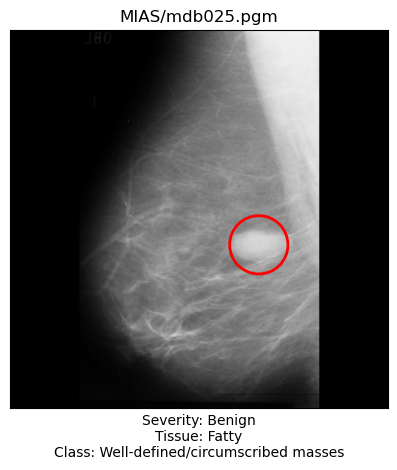

In [6]:
showMIAS(12)

## Step 4
#### Crop ROIs: Extract ROIs using annotations and display a sample.

In [7]:
# Folder to save cropped images
output_folder = 'MIAS/cropped_rois'
os.makedirs(output_folder, exist_ok=True)

# Iterate over each row in the DataFrame
for index, row in data.iterrows():
    image_path = row['Reference Number']

    # Getting coordinates and radius
    x, y, radius = int(row['X_Coordinate']), int(row['Y_Coordinate']), int(row['Radius'])

    # Adjusting Y 
    y = (-1 * y) + 1024
    
    # Load the image
    image = cv2.imread(image_path)

    # Create a circular mask
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.circle(mask, (x, y), radius, 255, -1)

    # Apply the mask to extract the ROI
    roi = cv2.bitwise_and(image, image, mask=mask)

    # Crop the bounding box of the circle
    x1, y1 = max(0, x - radius), max(0, y - radius)
    x2, y2 = x + radius, y + radius
    cropped_roi = roi[y1:y2, x1:x2]

    # Save the cropped ROI
    output_path = os.path.join(output_folder, f"cropped_{index}.png")
    cv2.imwrite(output_path, cropped_roi)

#### Showing a sample.

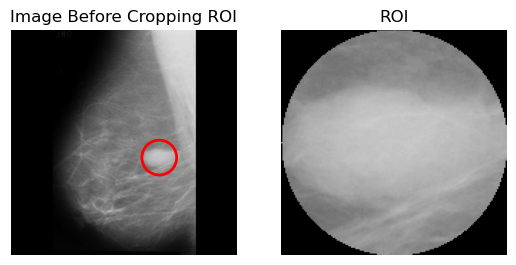

In [8]:
temp_image = cv2.imread(data.iloc[12]['Reference Number'])
ROI_temp = cv2.imread('MIAS/cropped_rois/cropped_25.png')
plt.figure()
plt.subplot(1,2,1)

center_x = int(data.iloc[12]['X_Coordinate'])
center_y = int(data.iloc[12]['Y_Coordinate'])
radius = int(data.iloc[12]['Radius'])
circle = plt.Circle((center_x, (1024 + (-1 * center_y))), radius, color='red', fill=False, linewidth=2)
plt.gca().add_artist(circle)
plt.title('Image Before Cropping ROI')
plt.axis('off')
plt.imshow(temp_image, cmap='gray')



plt.subplot(1,2,2)
plt.imshow(ROI_temp, cmap='gray')
plt.title('ROI')
plt.axis('off')
plt.show()


## Step 5
#### CLAHE Processing: Perform local histogram equalization using CLAHE with OpenCV and save the results in a separate folder for equalized images.

In [9]:
def local_histogram_equalization(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Perform local histogram equalization using CLAHE.

    Args:
        image (numpy.ndarray): Grayscale image (2D array).
        clip_limit (float): Threshold for contrast limiting.
        tile_grid_size (tuple): Size of the grid for dividing the image into tiles.

    Returns:
        numpy.ndarray: Locally equalized image.
    """
    # Create CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # Apply CLAHE to the image
    equalized_image = clahe.apply(image)
    return equalized_image

# Paths for the input and output folders
input_folder = 'MIAS/cropped_rois//'  
output_folder = 'MIAS/Equalized images'  

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Process each image in the input folder
for image_name in os.listdir(input_folder):
    input_path = os.path.join(input_folder, image_name)

    # Read the image
    image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Could not read image: {image_name}")
        continue

    # Apply local histogram equalization (CLAHE)
    equalized_image = local_histogram_equalization(image)

    # Save the equalized image to the output folder
    output_path = os.path.join(output_folder, image_name)
    cv2.imwrite(output_path, equalized_image)

print("Processing completed!")


Processing completed!


##### Image Comparison: Use Matplotlib to compare original images with their equalized counterparts side by side.

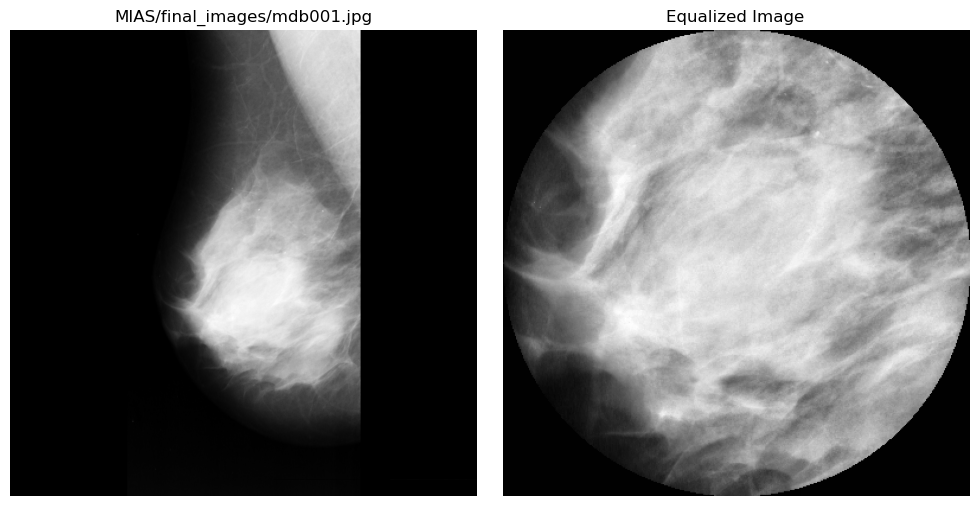

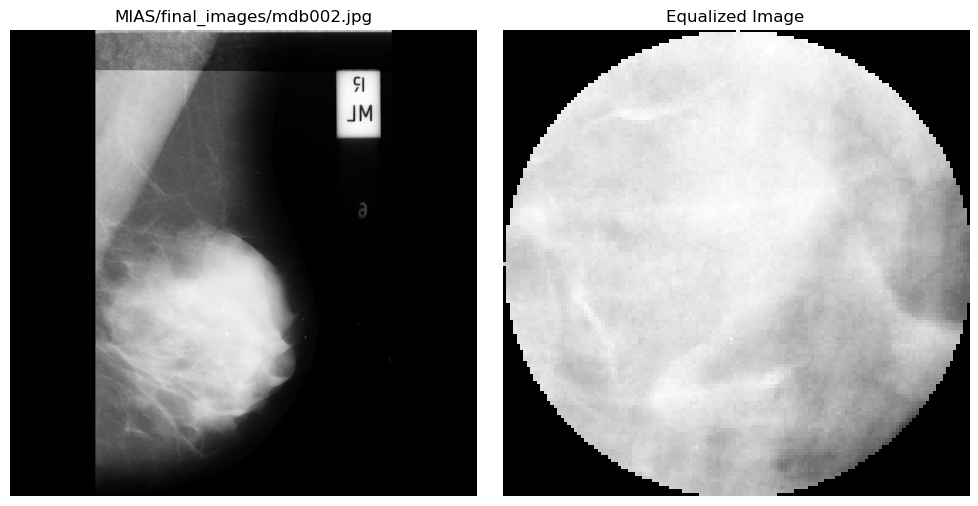

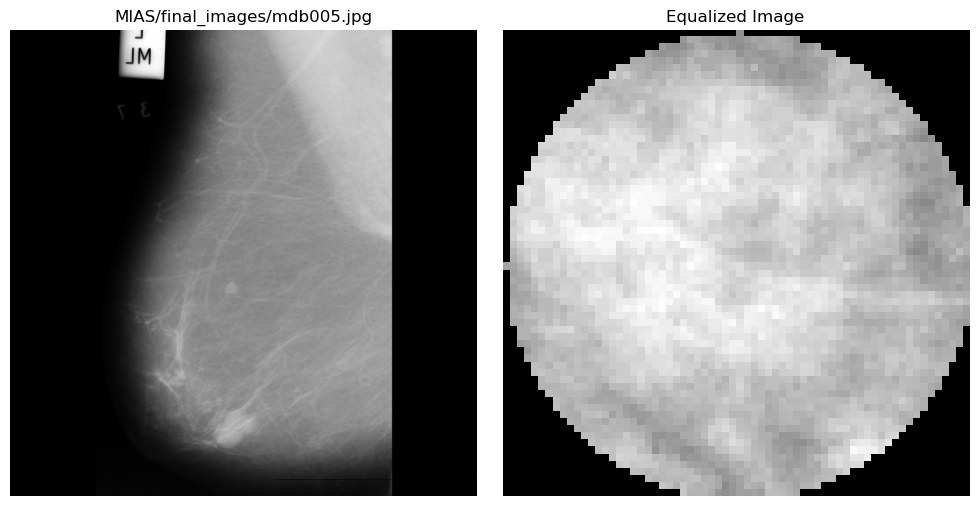

In [10]:
# Paths for the input and output folders
final_images_folder = 'MIAS/final_images/'  
equalized_images_folder = 'MIAS/Equalized images/' 

# List of image filenames in the folders
original_images = sorted(os.listdir(final_images_folder))
equalized_images = sorted(os.listdir(equalized_images_folder))

# Compare a few images
num_images_to_compare = 3

for i in range(num_images_to_compare):
    original_path = os.path.join(final_images_folder, original_images[i])
    equalized_path = os.path.join(equalized_images_folder, equalized_images[i])

    # Read the images in grayscale
    original_image = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
    equalized_image = cv2.imread(equalized_path, cv2.IMREAD_GRAYSCALE)

    # Plot the original and equalized images side by side
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.title(original_path)
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    # Equalized image
    plt.subplot(1, 2, 2)
    plt.title("Equalized Image")
    plt.imshow(equalized_image, cmap='gray')
    plt.axis('off')

    # Show the comparison
    plt.tight_layout()
    plt.show()


## Step 6
#### Noise Reduction and Comparison: Apply a Median filter to the equalized ROI images to remove noise and compare them with the original equalized ROI images using Matplotlib.

In [11]:
def apply_median_filter(input_folder, output_folder, kernel_size=3):
    """
    Apply median filtering to all images in a folder and save the results to a new folder.

    Parameters:
        input_folder (str): Path to the folder containing input images.
        output_folder (str): Path to save the filtered images.
        kernel_size (int): Kernel size for the median filter. Default is 3.

    Returns:
        None
    """
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Process each image in the input folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            # Read the image
            image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

            # Apply the median filter
            filtered_image = cv2.medianBlur(image, kernel_size)

            # Save the filtered image
            cv2.imwrite(output_path, filtered_image)


input_folder = "MIAS/Equalized images/"  # Replace with your input folder
output_folder = "MIAS/median"  # Replace with desired output folder name
apply_median_filter(input_folder, output_folder, kernel_size=3)
print('Process complete!')

Process complete!


## Step 7
#### Manual Thresholding with Seeded Region Growing: Apply seeded region growing on preprocessed images to determine thresholds manually by experimenting with various values, as the dataset lacks specific thresholds per image (as advised by the professor).

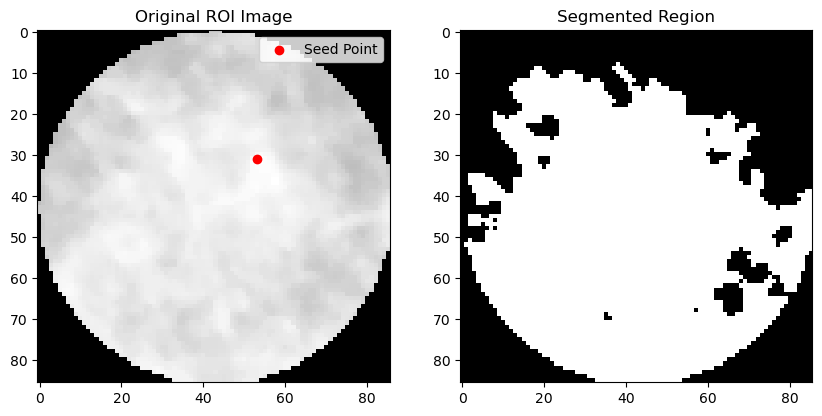

In [12]:
def seeded_region_growing(image, seed_point, threshold):
    """
    Perform seeded region growing segmentation.

    Parameters:
        image (numpy.ndarray): Input ROI image.
        seed_point (tuple): Maximum intensity coordinate in the image
        threshold (float): Threshold for stopping the region growing.

    Returns:
        numpy.ndarray: Segmented region mask.
    """

    # getting image's shape
    rows, cols = image.shape

    # Segmented region mask
    segmented = np.zeros_like(image, dtype=np.uint8)  

    # Track visited pixels
    visited = np.zeros_like(image, dtype=bool)       

    # Initializing seed point X and Y
    seed_x, seed_y = seed_point

    # getting the mean on region
    region_mean = image[seed_x, seed_y]  # Initialize region mean with seed intensity

    # Initialize a list of pixels to visit, starting with the seed point
    pixels_to_visit = [(seed_x, seed_y)]

    while pixels_to_visit:
        
        # Get the next pixel to process
        x, y = pixels_to_visit.pop(0)

        if visited[x, y]:
            continue

        visited[x, y] = True  # Mark pixel as visited

        # Compute the intensity difference
        intensity = image[x, y]
        intensity_difference = abs(intensity - region_mean)

        # Check if the pixel should be added to the region
        if intensity_difference <= threshold:
            
            segmented[x, y] = 255  # Mark pixel as part of the segmented region

            # Update the region mean
            region_pixels = image[segmented == 255]
            region_mean = np.mean(region_pixels)

            # Add 4-neighboring pixels to the queue
            neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]
            for nx, ny in neighbors:

                # New pixels should be in the image and not visited
                if 0 <= nx < rows and 0 <= ny < cols and not visited[nx, ny]:
                    
                    # adding these pixels to be processed next iteration
                    pixels_to_visit.append((nx, ny))

    return segmented

# Load Image
roi_image = cv2.imread('MIAS/median/cropped_30.png', cv2.IMREAD_GRAYSCALE)

# Determine seed point as the coordinates of the pixel with the highest intensity
max_intensity_index = np.unravel_index(np.argmax(roi_image, axis=None), roi_image.shape)
seed = max_intensity_index  # Seed point (x, y)

# Define threshold (Manual adjustment until get the best result)
threshold_t = 20  

# Perform seeded region growing
segmented_mask = seeded_region_growing(roi_image, seed, threshold_t)

# Display the segmented result using matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original ROI Image")
plt.imshow(roi_image, cmap="gray")
plt.scatter([seed[1]], [seed[0]], color="red", label="Seed Point")  # Highlight the seed point
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Segmented Region")
plt.imshow(segmented_mask, cmap="gray")

plt.show()


## Step 8
#### Extraction of Intensity Features:
    Mean
    Median
    Minimum Intensity
    Maximum Intensity
    Standard Deviation
    Entropy
    Skewness

In [13]:
def calculate_histogram_features(image):
    features = {}

    # Flatten the image to get pixel values
    pixels = image.flatten()

    # Calculate histogram
    hist, _ = np.histogram(pixels, bins=256, range=(0, 256), density=True)

    # Mean
    features['Mean'] = np.mean(pixels)

    # Variance
    features['Variance'] = np.var(pixels)

    # Skewness
    features['Skewness'] = skew(pixels)

    # Kurtosis
    features['Kurtosis'] = kurtosis(pixels)

    # Entropy
    hist = hist[hist > 0]  # Remove zeros to avoid log errors
    features['Entropy'] = -np.sum(hist * np.log2(hist))

    # Energy
    features['Energy'] = np.sum(hist ** 2)

    # Contrast
    gray_levels = np.arange(len(hist))  # Match the length of histogram bins
    mean_intensity = features['Mean']
    features['Contrast'] = np.sum(hist * (gray_levels - mean_intensity) ** 2)

    return features

def process_images_in_folder(folder_path):
    # Initialize an empty list to store data
    data = []

    # Loop through all images in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Add more formats if needed
            file_path = os.path.join(folder_path, filename)

            # Load image as grayscale
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            # Calculate features
            features = calculate_histogram_features(image)
            features['Image Name'] = filename 

            # Append features to the data list
            data.append(features)

    # Create a Pandas DataFrame
    df = pd.DataFrame(data)
    return df

# input folder
folder_path = 'MIAS/median/'

# Creating DataFrame
df = process_images_in_folder(folder_path)

# Save to a CSV file
df.to_csv('image_histogram_features.csv', index=False)


## Step 9
#### Dataset Preprocessing: Preprocess the dataset and add the manually estimated thresholds for each image.

In [14]:
# Reading the CSV file
df = pd.read_csv('image_histogram_features.csv')

# Processing file names in the dataframe for ease of access
df['Image Name'] = df['Image Name'].apply(lambda i: i.split('_')[-1].split('.')[0])
df['Image Name'] = df['Image Name'].astype(int)


# Sorting Data based on images' name
df = df.sort_values(by='Image Name')

# Manually Determined Thresholds: Thresholds were determined manually and added to the dataset.
thr = [30,30,30,37,17,29,40,40,40,18,49,49,45,30,15,28,32,32,20,19,50,60,50,40,40,40,37,34,56,40,40,29,20,50,30,40,45,45,45,45,45,55,55,80,40,40,40,40,35,40,45,40,30,70,70,30,40,46,46,30,30,50,50,60,60,40,30,30,30,60,40,30,25,60,60,60,50,50,40,50,50,55,60,5,40,40,40,40,65,55,55,60,50,60,65,65,60,60,50,50,40,40,30,59,40,30,70,40,50,55,40,30,40,40,50,50,50,70,40]
df['threshold'] = thr

# resetting indecies 
df.reset_index(drop=True, inplace=True)

# Saving dataframe as CSV file
df.to_csv('final.csv', index=False)


In [15]:
data = pd.read_csv('final.csv')
data

,Mean,Variance,Skewness,Kurtosis,Entropy,Energy,Contrast,Image Name,threshold
0,119.413706,5844.633687,-0.478619,-1.316367,6.608286,0.049412,5673.806299,0,30
1,153.896345,6806.667580,-1.130325,-0.451323,5.859626,0.049764,6438.209231,1,30
2,126.114444,4359.174125,-0.993459,-0.582855,5.904575,0.054236,5127.967031,4,30
3,135.263314,4585.954335,-1.160236,-0.346305,5.697158,0.052756,7265.372886,5,37
4,153.808540,6440.221378,-1.149766,-0.349199,5.845893,0.051744,13033.745554,10,17
...,...,...,...,...,...,...,...,...,...
114,114.956772,4122.975757,-0.861452,-0.606123,5.917402,0.056153,6280.042341,281,50
115,117.825185,7029.066230,-0.517119,-1.525138,5.216611,0.121323,6425.383547,297,50
116,148.892500,4813.934694,-1.150661,-0.322504,5.762618,0.050395,10541.738484,319,50
117,143.342045,5509.724393,-1.197687,-0.271776,5.672378,0.054883,11999.262820,321,70


## Step 10
#### Threshold Prediction with ANN: Use an Artificial Neural Network (ANN) to learn from intensity features of each image and predict thresholds for segmentation in the seeded region growing process.

In [16]:
# Load your data (replace with your actual file if needed)
data = pd.read_csv('final.csv')

# Features and target selection
X = data[['Mean', 'Variance', 'Skewness', 'Kurtosis', 'Entropy', 'Energy', 'Contrast']]
y = data['threshold']

# Normalize the features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Build the ANN model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.3, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

Epoch 1/100
9/9 [==============================] - 2s 18ms/step - loss: 1899.4708 - mae: 41.8667 - val_loss: 1737.9307 - val_mae: 39.4841
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 1670.1816 - mae: 39.0792 - val_loss: 1392.5148 - val_mae: 34.7809
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 1152.1893 - mae: 31.8671 - val_loss: 705.2403 - val_mae: 23.0023
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 419.3663 - mae: 16.6229 - val_loss: 232.8073 - val_mae: 12.5193
Epoch 5/100
9/9 [==============================] - 0s 5ms/step - loss: 296.7377 - mae: 13.0444 - val_loss: 312.7629 - val_mae: 14.6839
Epoch 6/100
9/9 [==============================] - 0s 5ms/step - loss: 204.4891 - mae: 10.8813 - val_loss: 232.5902 - val_mae: 12.3201
Epoch 7/100
9/9 [==============================] - 0s 5ms/step - loss: 205.6002 - mae: 11.4688 - val_loss: 223.0123 - val_mae: 12.0675
Epoch 8/100
9/9 [==============================] 

##### Mean Absolute Error (MAE)
##### Mean Squared Error (MSE)
##### R² Score

In [17]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 12.742066224416098
Mean Squared Error (MSE): 232.9190822943283
R² Score: -0.07172213001392436


## Step 11
#### Dataset with Predicted Thresholds: Create a new dataset incorporating thresholds predicted by the ANN for each image.

In [18]:
# getting a new data frame by copying
new_dataset = data.copy()

# Updating images' names for convenience
updated_image_names = ['MIAS/median/cropped_' + str(i) + '.png' for i in new_dataset['Image Name']]
new_dataset['Image Name'] = updated_image_names


# Adding predicted thresholds to the data frame
predicted = model.predict(X_normalized)
new_dataset['Predicted Thresholds'] = predicted

# Showing new data frame
final_data = new_dataset[['Image Name', 'threshold', 'Predicted Thresholds']]
final_data

4/4 [==============================] - 0s 1ms/step


,Image Name,threshold,Predicted Thresholds
0,MIAS/median/cropped_0.png,30,47.320099
1,MIAS/median/cropped_1.png,30,43.205696
2,MIAS/median/cropped_4.png,30,46.001549
3,MIAS/median/cropped_5.png,37,44.050617
4,MIAS/median/cropped_10.png,17,42.433937
...,...,...,...
114,MIAS/median/cropped_281.png,50,46.219006
115,MIAS/median/cropped_297.png,50,38.551491
116,MIAS/median/cropped_319.png,50,44.713959
117,MIAS/median/cropped_321.png,70,42.147957


## Step 12
### Seeded Region Growing and Storage:

#### Apply seeded region growing with predicted thresholds and save the segmented images.
#### Apply seeded region growing with manually calculated thresholds and save the ground truth images for comparison.

In [19]:
# Ensure the destination directory exists
destination = 'MIAS/segmented/'
os.makedirs(destination, exist_ok=True)

# Creating an empty list for segmented image paths
segmented_images_paths = []

# Iterate over the rows of the dataset
for _, row in new_dataset.iterrows():
    im = row['Image Name']  # Path to the image
    threshold = row['Predicted Thresholds']  # Use 'predicted threshold' for thresholding 

    # Read the image in grayscale
    image = cv2.imread(im, cv2.IMREAD_GRAYSCALE)


    # Find the point of maximum intensity as seed point
    max_intensity_index = np.unravel_index(np.argmax(image, axis=None), image.shape)
    seed = max_intensity_index  # Seed point (x, y)

    # Perform region growing segmentation (Using the Seeded Region Growing Segmentation Function in STEP 7)
    segmented_mask = seeded_region_growing(image, seed, threshold)

    # Save the segmented mask
    output_path = os.path.join(destination, os.path.basename(im))
    cv2.imwrite(output_path, segmented_mask)
    segmented_images_paths.append(output_path)

In [20]:
# Ensure the destination directory exists
destination = 'MIAS/ground truth/'
os.makedirs(destination, exist_ok=True)

# Creating an empty list for ground truth image paths
ground_truth_images_paths = []

# Iterate over the rows of the dataset
for _, row in new_dataset.iterrows():
    im = row['Image Name']  # Path to the image
    threshold = row['threshold']  # Use 'predicted threshold' for thresholding 

    # Read the image in grayscale
    image = cv2.imread(im, cv2.IMREAD_GRAYSCALE)


    # Find the point of maximum intensity as seed point
    max_intensity_index = np.unravel_index(np.argmax(image, axis=None), image.shape)
    seed = max_intensity_index  # Seed point (x, y)

    # Perform region growing segmentation (Using the Seeded Region Growing Segmentation Function in STEP 7)
    segmented_mask = seeded_region_growing(image, seed, threshold)

    # Save the ground truth images
    output_path = os.path.join(destination, os.path.basename(im))
    cv2.imwrite(output_path, segmented_mask)
    ground_truth_images_paths.append(output_path)

## Step 13
#### Updating the data frame with segmented and ground truth images paths

In [21]:
final_data['Segmented'] = segmented_images_paths
final_data['Ground Truth'] = ground_truth_images_paths

final_data.to_csv('new dataset.csv',index=False)
final_data

C:\Users\erfan\AppData\Local\Temp\ipykernel_32552\469736472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Segmented'] = segmented_images_paths
C:\Users\erfan\AppData\Local\Temp\ipykernel_32552\469736472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Ground Truth'] = ground_truth_images_paths


,Image Name,threshold,Predicted Thresholds,Segmented,Ground Truth
0,MIAS/median/cropped_0.png,30,47.320099,MIAS/segmented/cropped_0.png,MIAS/ground truth/cropped_0.png
1,MIAS/median/cropped_1.png,30,43.205696,MIAS/segmented/cropped_1.png,MIAS/ground truth/cropped_1.png
2,MIAS/median/cropped_4.png,30,46.001549,MIAS/segmented/cropped_4.png,MIAS/ground truth/cropped_4.png
3,MIAS/median/cropped_5.png,37,44.050617,MIAS/segmented/cropped_5.png,MIAS/ground truth/cropped_5.png
4,MIAS/median/cropped_10.png,17,42.433937,MIAS/segmented/cropped_10.png,MIAS/ground truth/cropped_10.png
...,...,...,...,...,...
114,MIAS/median/cropped_281.png,50,46.219006,MIAS/segmented/cropped_281.png,MIAS/ground truth/cropped_281.png
115,MIAS/median/cropped_297.png,50,38.551491,MIAS/segmented/cropped_297.png,MIAS/ground truth/cropped_297.png
116,MIAS/median/cropped_319.png,50,44.713959,MIAS/segmented/cropped_319.png,MIAS/ground truth/cropped_319.png
117,MIAS/median/cropped_321.png,70,42.147957,MIAS/segmented/cropped_321.png,MIAS/ground truth/cropped_321.png


## Step 14
#### Image Comparison: Compare original images, segmented images (using predicted thresholds), and ground truth images (using manually calculated thresholds) side by side for evaluation.

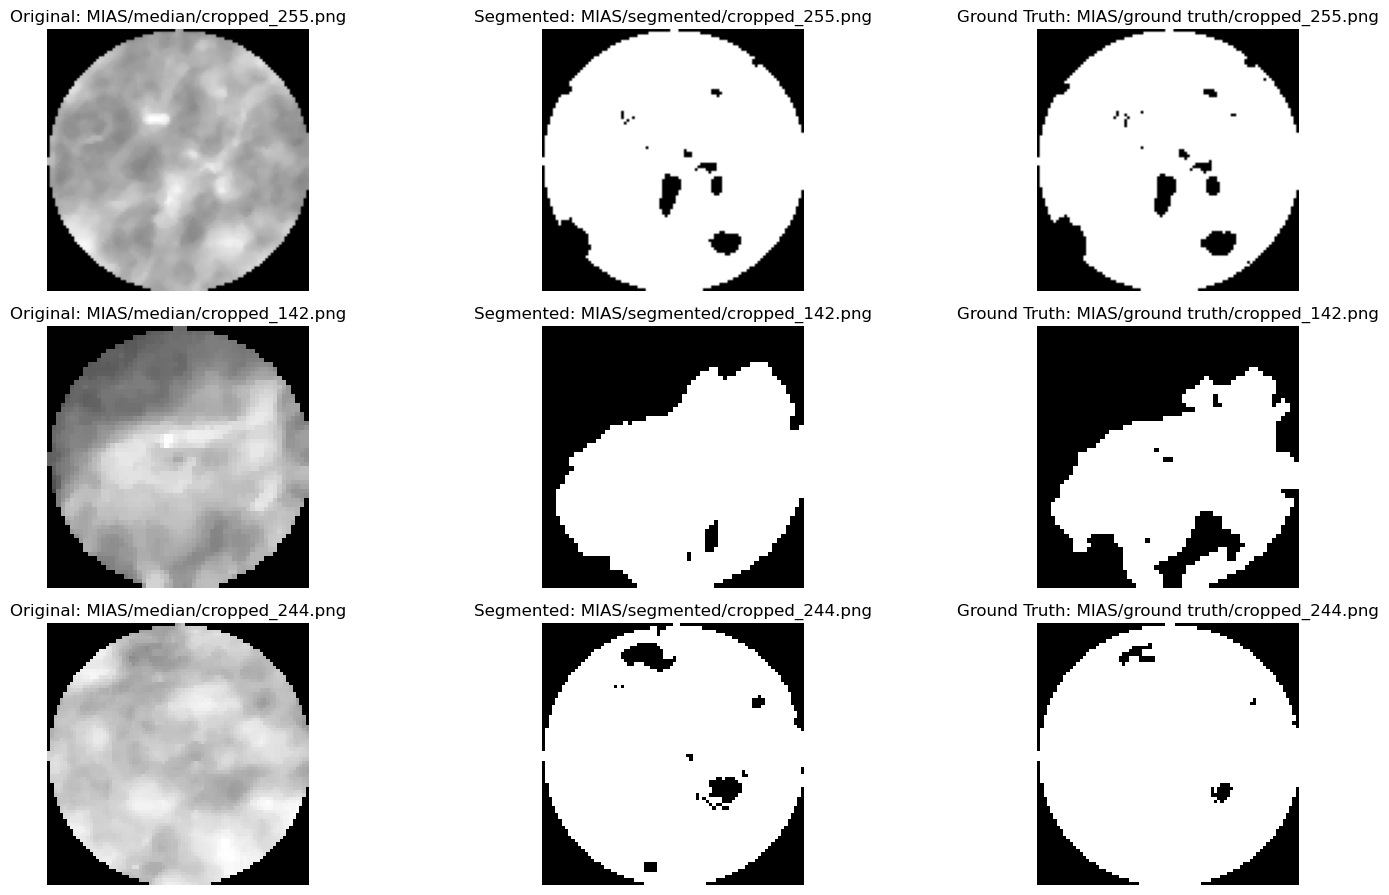

In [22]:
# Loading the data frame
new_dataset = pd.read_csv('new dataset.csv')

# Select 3 random rows from the dataset
random_rows = new_dataset.sample(n=3)

# Initialize a figure
plt.figure(figsize=(15, 15))

# Loop through the 3 random rows
for idx, row in enumerate(random_rows.itertuples(), 1):
    # Read the original image
    image_name = row[1]  # from 'Image Name' column
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Read the segmented image
    segmented_image_name = row[4]  # from 'Segmented' column
    segmented_image = cv2.imread(segmented_image_name, cv2.IMREAD_GRAYSCALE)

    # Read the ground truth image
    ground_truth_name = row[5]  # from 'Ground Truth' column
    ground_truth_image = cv2.imread(ground_truth_name, cv2.IMREAD_GRAYSCALE)

    # Add the original image to the plot
    plt.subplot(5, 3, 3 * idx - 2)
    plt.imshow(image, cmap='gray')
    plt.title(f"Original: {image_name}")
    plt.axis('off')

    # Add the segmented image to the plot
    plt.subplot(5, 3, 3 * idx - 1)
    plt.imshow(segmented_image, cmap='gray')
    plt.title(f"Segmented: {segmented_image_name}")
    plt.axis('off')

    # Add the ground truth image to the plot
    plt.subplot(5, 3, 3 * idx)
    plt.imshow(ground_truth_image, cmap='gray')
    plt.title(f"Ground Truth: {ground_truth_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Step 15
#### Performance Metrics: Calculate DICE and Jaccard metrics to evaluate the similarity between segmented images and ground truth images.

In [23]:
# Creating DICE function
def compute_dice_coefficient(gt, pred):
    intersection = np.sum((gt == 1) & (pred == 1))
    dice = (2 * intersection) / (np.sum(gt == 1) + np.sum(pred == 1))
    return dice

# Creating Jaccard function
def compute_jaccard_index(gt, pred):
    intersection = np.sum((gt == 1) & (pred == 1))
    union = np.sum((gt == 1) | (pred == 1))
    jaccard = intersection / union
    return jaccard

# Paths to folders of Segmented and Ground truth images
ground_truth_folder = "MIAS/ground truth/"
predicted_folder = "MIAS/segmented/"

# Evaluate all images
dice_scores = []
jaccard_scores = []

# Getting the image paths
ground_truth_files = sorted(os.listdir(ground_truth_folder))
predicted_files = sorted(os.listdir(predicted_folder))

for gt_file, pred_file in zip(ground_truth_files, predicted_files):
    gt_path = os.path.join(ground_truth_folder, gt_file)
    pred_path = os.path.join(predicted_folder, pred_file)
    
    # Load masks with normalizing to (0 to 1)
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE) // 255  
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE) // 255
    
    # Ensure same size
    if gt_mask.shape != pred_mask.shape:
        pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]))
    
    # Compute metrics
    dice = compute_dice_coefficient(gt_mask, pred_mask)
    jaccard = compute_jaccard_index(gt_mask, pred_mask)
    
    dice_scores.append(dice)
    jaccard_scores.append(jaccard)

# Average scores
average_dice = np.mean(dice_scores)
average_jaccard = np.mean(jaccard_scores)

print(f"Average Dice Coefficient: {average_dice:.4f}")
print(f"Average Jaccard Index: {average_jaccard:.4f}")


Average Dice Coefficient: 0.9390
Average Jaccard Index: 0.9110


###### Second Dataset (Which does not have Annotation (X, Y, Radius Coordinates)

## Importing DDSM dataset.

but as I could not download the dataset from the link in the paper I downloaded the dataset from Kaggle which did not contain coordinates

### The images are labeled with two labels:

##### label_normal 
        0 for negative
        1 for positive
##### label - full multi-class labels,
        0 is negative,
        1 is benign calcification,
        2 is benign mass,
        3 is malignant calcification,
        4 is malignant mass
The following Python code will decode the training examples:

In [24]:

# Define a function to parse the TFRecords
def parse_tfrecord(serialized_example):
    # Define the feature schema
    feature_description = {
        'label_normal': tf.io.FixedLenFeature([], tf.int64),  # Binary label: 0 (negative), 1 (positive)
        'label': tf.io.FixedLenFeature([], tf.int64),  # Multi-class label
        'image': tf.io.FixedLenFeature([], tf.string),  # Raw image data as bytes
    }
    
    # Parse the serialized example
    features = tf.io.parse_single_example(serialized_example, feature_description)
    
    # Decode the image from raw bytes
    image = tf.io.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, [299, 299, 1])  # Reshape based on known dimensions

    # Return the labels and image
    return features['label_normal'], features['label'], image

# Path to TFRecord file
tfrecord_path = 'DDSM Mammography/training10_0/training10_0.tfrecords'

# Create a TFRecordDataset
dataset = tf.data.TFRecordDataset(tfrecord_path)

# Parse the dataset
parsed_dataset = dataset.map(parse_tfrecord)

# Convert the dataset to a DataFrame
def dataset_to_table(dataset, num_samples=100):
    data = []
    for label_normal, label, image in dataset.take(num_samples):
        # Convert tensors to numpy for easier handling
        label_normal_value = label_normal.numpy()
        label_value = label.numpy()
        image_array = image.numpy()  # Store the raw image as a NumPy array
        data.append({
            "Multi-class Label": label_normal_value,
            "Label": label_value,
            "Image Shape": image_array.shape,
            "Image": image_array,
        })
    return data

# Convert parsed dataset to a table
data_list = dataset_to_table(parsed_dataset, num_samples=10)  # Adjust num_samples as needed
df = pd.DataFrame(data_list)

# Display the DataFrame
df.head(20)


,Multi-class Label,Label,Image Shape,Image
0,0,0,"(299, 299, 1)","[[[66], [68], [74], [79], [84], [86], [85], [8..."
1,0,0,"(299, 299, 1)","[[[47], [47], [48], [49], [48], [49], [48], [4..."
2,0,0,"(299, 299, 1)","[[[20], [20], [19], [19], [19], [19], [20], [2..."
3,1,4,"(299, 299, 1)","[[[159], [161], [162], [161], [160], [164], [1..."
4,0,0,"(299, 299, 1)","[[[132], [134], [133], [133], [135], [133], [1..."
5,0,0,"(299, 299, 1)","[[[64], [64], [63], [66], [65], [64], [65], [6..."
6,1,4,"(299, 299, 1)","[[[192], [191], [189], [190], [190], [190], [1..."
7,0,0,"(299, 299, 1)","[[[160], [159], [161], [165], [169], [174], [1..."
8,1,2,"(299, 299, 1)","[[[117], [121], [120], [119], [119], [119], [1..."
9,0,0,"(299, 299, 1)","[[[103], [105], [102], [104], [106], [108], [1..."


A function for showing detailed images from the DDSM dataset.

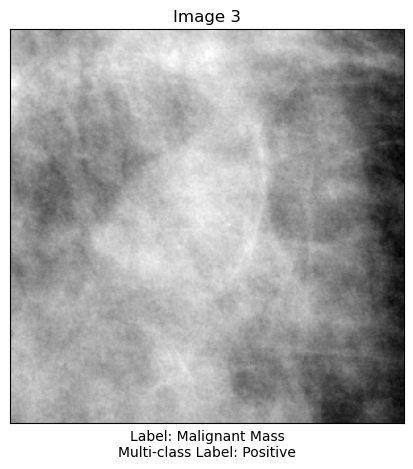

In [25]:
def showDDSM(number):
    im = df['Image'][number]
    
    multilabel_dict = {0: "Negative", 1: "Positive"}
    label_dict = {0: "Negative", 1: "Benign Calcification", 2: "Benign Mass", 3: "Malignant Calcification", 4: "Malignant Mass"}

    label = label_dict.get(df['Label'][number], "Unknown Label")
    multilabel = multilabel_dict.get(df['Multi-class Label'][number], "Unknown Label")
    
    plt.imshow(im, cmap='gray')
    plt.title(f'Image {number}')
    plt.xlabel(f'Label: {label}\nMulti-class Label: {multilabel}')
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.tight_layout()
    plt.show()

showDDSM(3)